# Assignment Jan 2019. A building pit next to a river

:author: T.N.Olsthoorn, 2019-01-04, june 2022

## Problem statement

![Situations sketch](../LyX/pictures/AssJan2019_1.png)

1. A large construction is to be realized next to a river that is in direct contact with the aquifer next to it. The building pit measures 50x50 m and river side is at 400 m distance from the river shore.

2. Transmissivity and storage coefficient are given: $kD=900\,\mathrm{m^{2}/d}$, $S^{=}0.25$.

3. The drawdown everywhere in the building pit must be at least 5 m, to be reached within one month of pumping.

4. The pumping will continue after this month for 5 more months during which the drawdown is to be maintained. However the pumping can be reuced after the first month. Adjust the pumping once per month, such that at the end of each month the darwdown fullfils the requied 5 m.

5. After 6 months, pumping is stopped, so that the water levels can restore.

## Questions


1. On which two corners of the builing pit should you place the two extraction wells to have most effect.

2. Find the most critical point and make sure that the drawdown is as required at that point.

3. Show the extraction as a function of time from the start until one year after the stop. Also plot the drawdown at the critical location for this period.

4. Compute as a function of time the flow from the river into the groundwater system. It is assumed that the groundwater head is initially uniform and equal to the river stage (water level in the river). Do this for the averate flow during the 6 month of building pit operation (ignore the variation in the extraction for simplicity).

5. How much time is required after stopping until about 90% of the drawdown has disappeared?


6. After exactly 3 months, the water level in the river rises suddenly by 1 m and stays so during one month, after which it suddenly returns to its original level.

    To what extent does this wave affect the water level in the building pit if no measure is taken?

    What must be the extraction during this month to guarantee that the building pit fulfills the required 5 m drawdown relative to the original water level? If both effects do not overlap, say so, and explain what you could to as building-pit owner to better counteract the effect of the wave  in the river stage on the head below the building pit

7. If the river is influenced by sea tide, such that its level fluctuates twice a day between +1 and -1 m relative to the average value. How does this tide influence the required pumping? Is the location of the most critical point still the same?

    How much is the delay between the tide in the river and the fluctuation at the critical point in the building pit?



## Hints

1. Work out the assigment in this Jupyter notebook. Take some time to become familiar with it. There is a tremendous amount of help on the internet to get you going. The site on `github.com/Olsthoorn/TransientGroundwaterFlow` hold numerous examples from the syllabus in the form of `jupyter notebooks`.

2. Also refer to the notebooks for the second year students of the TUDelft by Mark bakker (search for `Bakker exploratory` computing to find them).

3. You will gain some experience with the Notebooks (see their help)

    a) with python

    b) with numpy

    c) with functions in scipy

4. Make sure your assigment is a self-contained document, that you could also export as html or pdf for sharing to those who do not have python installed.

## Modules you wil need are imported here

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1 # Theis well function
from scipy.special import erfc

# import the necessary fucntionality
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1 as W # Theis well function



## Convenient plotting functions



In [26]:
def newfig(title='?', xlabel='?', ylabel='?', xlim=None, ylim=None, xscale=None, yscale=None, figsize=(10, 8),
            fontsize=16):
    sizes = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']
    
    assert isinstance(fontsize, int) or fontsize in sizes, \
        "fontsize not int and not in [{}]".format(', '.join(sizes))
                
    _, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    ax.grid()
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)
    return ax

def newfigs(layout, titles=['?'], xlabels=['?'], ylabels=['?'], xscales=None, yscales=None,
            xlim=None, ylim=None, sharex=None, sharey=None, fontsize=16, figsize=(10, 8)):
    sizes = ['xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large']
    
    assert isinstance(fontsize, int) or fontsize in sizes, \
        "fontsize not int and not in [{}]".format(', '.join(sizes))
                
    fig, axs = plt.subplots(*layout, sharex=sharex, sharey=sharey)
    fig.set_size_inches(figsize)

    assert isinstance(layout, tuple) and len(layout) == 2, 'layout must be a 2-tuple (nrows, ncols) not {}'.format(str(layout))
    n_axes = np.prod(layout)
    
    if xscales is None: xscales = [None for _ in range(n_axes)]
    if yscales is None: yscales = [None for _ in range(n_axes)]
        
    for items_name, items in zip(['titles', 'xlabels', 'ylabels', 'xscales', 'yscales'], [titles, xlabels, ylabels, xscales, yscales]):
        assert len(items) == np.prod(layout), 'len({}) == {} != len(layout) == {}'.format(items_name, len(items), len(np.prod(layout)))
        
    for ax, title, xlabel, ylabel, xscale, yscale in zip(axs, titles, xlabels, ylabels, xscales, yscales):        
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim)
        if xscale: ax.set_xscale(xscale)
        if yscale: ax.set_yscale(yscale)
        ax.grid()
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return axs

## Setup the situation, define the wells and observation point

In [27]:
kD, S = 900, 0.25 # m2/d, (-)

W, B, L = 50., 50., 400 
# The building pit
pit = {'ul': {'x':-B/2,  'y':-L},
       'ur': {'x':+B/2,  'y':-L},
       'lr': {'x':+B/2,  'y':-L-B},
       'll': {'x':-B/2,  'y':-L-B},
       'mid': {'x':  0., 'y':-L},
       'ctr' : {'x': 0., 'y':-L-B/2},
       'crit': {'x': 0., 'y':-L-B},
}

# The . This is also the answer to Q1, the wells are at the two corners closest to the river.
wells ={1: {'type': 'wel', 'sign':+1, 'x':-B/2, 'y':-L},
        2: {'type': 'wel', 'sign':+1, 'x':+B/2, 'y':-L},
        3: {'type': 'mir', 'sign':-1, 'x':+B/2, 'y':+L},
        4: {'type': 'mir', 'sign':-1, 'x':-B/2, 'y':+L},
        
}

regime = dict()
regime['dates'] = np.array([np.datetime64(f'2020-{mm:02d}-01') for mm in np.arange(1, 13,  dtype=int)])

regime['Q'] = np.array([-1325., -1200., -1150., -1100., -1100., -1100., 0., 0., 0., 0., 0., 0.,]) * 5 # Initially guessed pumping regime.
regime['dQ'] = np.diff(np.hstack((0, regime['Q'])))

regime['stage'] = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,] # river stage
regime['dstage'] = np.diff(np.hstack((0, regime['stage']))) # river change stage.

tstart = regime['dates'][0]
tsim = np.arange(tstart, tstart + np.timedelta64(366, 'D'))

### Fulfilling the required drawdown


Q1: The two wells must be placed on the two corners of the building pit closest to the river. But because of the river, we also have to place two mirror wells on the opposite site with the opposite sign. These wells heve been defined in the dict 'wells' above.

Q2: The most critical point is the center of mid of the line of the building point that is farthest from the river.

Q3: After some trial and error, the regime['Q'] establishese the desired steady drawdown after one month of pumpiong.

Q4: The data at which the dradown is again less than 0.5 m is shown in the figure with the error and the thick dot.

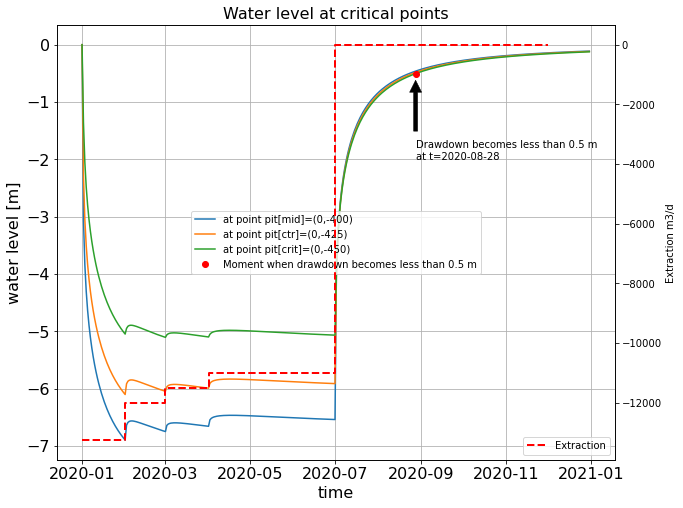

In [28]:

ax = newfig(f'Water level at critical points', 'time', 'water level [m]')

for kp in ['mid', 'ctr', 'crit']:
    x0, y0 = pit[kp]['x'], pit[kp]['y']

    s = np.zeros_like(tsim, dtype=float)
    
    for dQ, change_date in zip(regime['dQ'], regime['dates']):
        t = (tsim[tsim > change_date] - change_date) / np.timedelta64(1, 'D')

        for kw in wells:
            well = wells[kw]
            dx_, dy_ = x0 - well['x'], y0 - well['y']
            r2 = dx_ ** 2 + dy_ ** 2
            u = r2 * S / (4 * kD * t)
            s[tsim > change_date] += well['sign'] * dQ / (4 * np.pi * kD) * exp1(u)

    ax.plot(tsim, s, label=f'at point pit[{kp}]=({x0:.0f},{y0:.0f})')
    
if True:
    criterion = np.logical_and(tsim > np.datetime64('2020-07-01'), s <= -0.5)
    ts, ss = tsim[criterion][-1], s[criterion][-1]

    ax.plot(ts, ss, 'ro', label='Moment when drawdown becomes less than 0.5 m')
    ax.annotate(f'Drawdown becomes less than 0.5 m\nat t={ts}', xy=(ts, ss), xycoords='data', xytext=(ts, -2), textcoords='data', arrowprops=dict(facecolor='black', linewidth=0.5, shrink=0.1))
ax.legend(loc='center')

ax1 = ax.twinx()
ax1.set_ylabel('Extraction m3/d')

nwells = np.sum([wells[k]['type']=='wel' for k in wells])

ax1.step(regime['dates'], nwells * regime['Q'], 'r--', lw=2, where='post', label='Extraction')
ax1.legend(loc='lower right')


### River-stage change

Q6: What happens to the groundwater levels due to the change in the river stage?

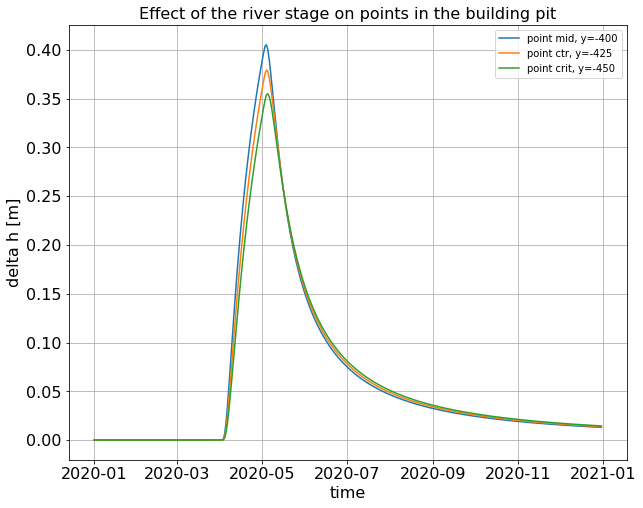

In [30]:
dstages       = regime['dstage'][regime['dstage'] != 0]
change_dates  = regime['dates' ][regime['dstage'] != 0]

ax = newfig("Effect of the river stage on points in the building pit", "time", "delta h [m]")

for k in ['mid', 'ctr', 'crit']:
    yp = pit[k]['y']
    s = np.zeros_like(tsim, dtype=float)
    dy = 0 - yp # distance from the river (river is at x=0 m)
    for dstage, change_date in zip(dstages, change_dates):
        t = (tsim[tsim > change_date] -change_date) / np.timedelta64(1, 'D')
        u = dy * np.sqrt(S / (4 * kD * t))
        s[tsim > change_date] += dstage * erfc(u)
    ax.plot(tsim, s, label=f'point {k}, y={yp:.0f}')
ax.legend()
    

### Impact of the month-long wave in the river stage

Q6: Compensate for the effect of the change of the river stage.

We should superimpose this change on the drawdown by the wells and adapt the well regime to compensate for this stage change.

We should generate an extra drawdown of 0.4 m at the end of month 4. For this the regime has to be adapated

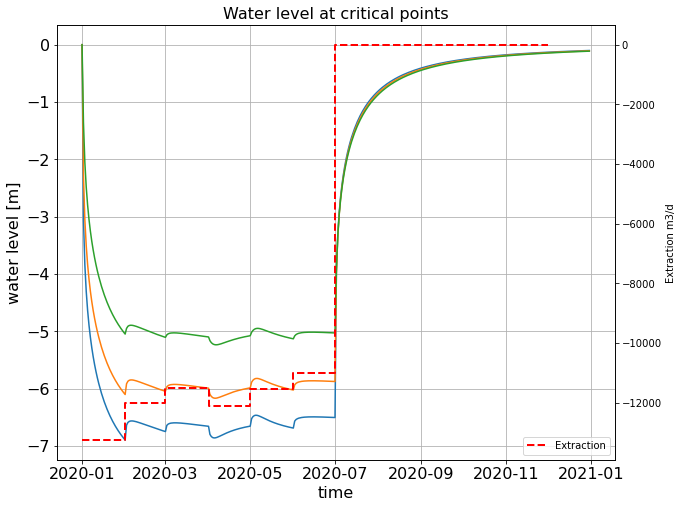

In [38]:
regime['Q'] = np.array([-1325., -1200., -1150., -1100., -1100., -1100., 0., 0., 0., 0., 0., 0.,]) * 5 # Initially guessed pumping regime.

# Extraction that compensates for the river srage change
# Set both to 1 to see what happens without extra pumping.
regime['Q'][3] *= 1.10
regime['Q'][4] *= 1.05

regime['dQ'] = np.diff(np.hstack((0, regime['Q'])))

ax = newfig(f'Water level at critical points', 'time', 'water level [m]')

for kp in ['mid', 'ctr', 'crit']:
    xp, yp = pit[kp]['x'], pit[kp]['y']
    dy = 0 - yp # distance from the river (river is at x=0 m)

    s = np.zeros_like(tsim, dtype=float)
    
    for dQ, change_date in zip(regime['dQ'], regime['dates']):
        t = (tsim[tsim > change_date] - change_date) / np.timedelta64(1, 'D')

        for kw in wells:
            well = wells[kw]
            dx_, dy_ = xp - well['x'], yp - well['y']
            r2 = dx_ ** 2 + dy_ ** 2
            u = r2 * S / (4 * kD * t)
            s[tsim > change_date] += well['sign'] * dQ / (4 * np.pi * kD) * exp1(u)

    for dstage, change_date in zip(dstages, change_dates):
        t = (tsim[tsim > change_date] -change_date) / np.timedelta64(1, 'D')
        u = dy * np.sqrt(S / (4 * kD * t))
        s[tsim > change_date] += dstage * erfc(u)
        
    ax.plot(tsim, s, label=f'at point pit[{kp}]=({x0:.0f},{y0:.0f})')
    

ax1 = ax.twinx()
ax1.set_ylabel('Extraction m3/d')

nwells = np.sum([wells[k]['type']=='wel' for k in wells])

ax1.step(regime['dates'], nwells * regime['Q'], 'r--', lw=2, where='post', label='Extraction')
ax1.legend(loc='lower right')

## Impact of river tide

The impact is shown below. The penetration depth of the tide is so small compared to the distance between the river and the building pit, that no measures have to be taken.

Of course, in the case of a lower frequency tide, like two-monthly extra high tides, and storm tides, pentration depth will be larger and this compensation may become necessary.

The same is true for high river stages that persist over longer times than only one month and with much higher values. during wet periods.

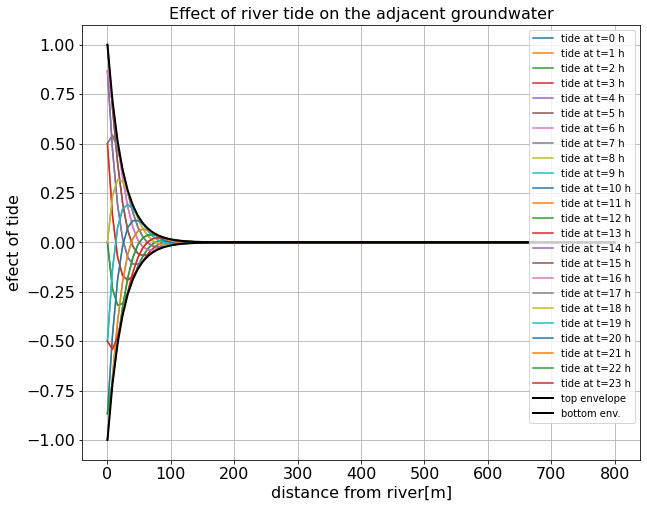

In [42]:
A, T = 1.0, 0.5 # Amplitude (m), cycle time (d)

omega = 2 * np.pi / T
a = np.sqrt(omega * S / (2 * kD))

show_times = np.arange(24, dtype=float) / 24

Y = np.linspace(0, 2 * L, 101) # keep sign postiive use negative Y only in the graph

ax =newfig("Effect of river tide on the adjacent groundwater", "distance from river[m]", "efect of tide")
env = A * np.exp(-a * Y)
for show_time in show_times:
    s = env * np.sin(omega * show_time - a * Y )
    ax.plot(Y, s, label=f'tide at t={show_time * 24:.0f} h')
ax.plot(Y, +env, 'k', lw=2, label='top envelope')
ax.plot(Y, -env, 'k', lw=2, label='bottom env.')
ax.legend(loc='upper right')
plt.show()

## How much water is extracted from the river?

$$ Q_r  = Q e^{-u} $$

$$ q_r = \frac Q {2 \pi r} e^{-u} $$

$$ q_x = \frac Q {2 \pi} e^{-u} \frac{x - x_w}{r^2} $$

$$ q_y = \frac Q {2 \pi} e^{-u} \frac{y - y_w}{r^2}$$


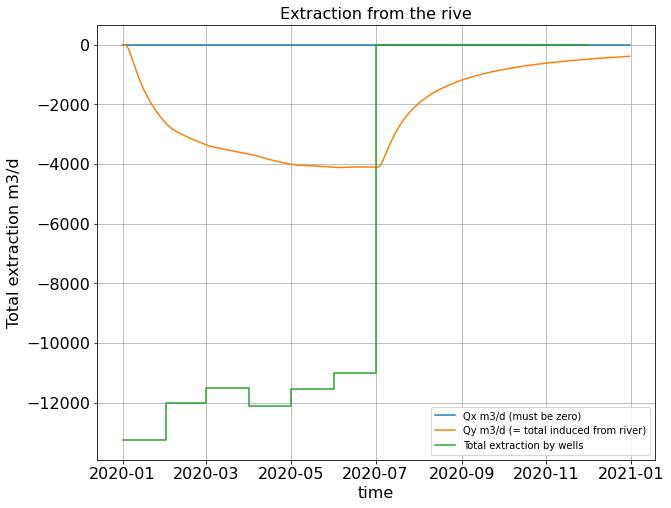

In [50]:
dx_, dy_ = xp - well['x'], yp - well['y']
r2 = dx_ ** 2 + dy_ ** 2

a = 5
xx = np.logspace(2, np.log10(a * L), 50)
Xr = np.hstack((-xx[::-1], 0, xx))[:, np.newaxis]
Yr = np.zeros_like(Xr)

qy = np.zeros((len(Yr), len(tsim)))
qx = np.zeros_like(qy)

for dQ, change_date in zip(regime['dQ'], regime['dates']):
    t = (tsim[tsim > change_date] - change_date) / np.timedelta64(1, 'D')
    
    for k in wells:
        well = wells[k]
        dx_, dy_ = Xr - well['x'], Yr - well['y']
        r2 = dx_ ** 2 + dy_ ** 2
        u = r2 * S / (4 * kD * t)
        qx[:, tsim > change_date] += well['sign'] * dQ / (2 * np.pi) * np.exp(-u) * dx_ / r2
        qy[:, tsim > change_date] += well['sign'] * dQ / (2 * np.pi) * np.exp(-u) * dy_ / r2
        
Qx = np.sum(0.5 * (qx[:-1,:] +  qx[1:, :]) * np.diff(Xr, axis=0), axis=0)
Qy = np.sum(0.5 * (qy[:-1,:] +  qx[1:, :]) * np.diff(Xr, axis=0), axis=0)

ax = newfig("Extraction from the rive", "time", "Total extraction m3/d")
ax.plot(tsim, Qx, label='Qx m3/d (must be zero)')
ax.plot(tsim, Qy, label='Qy m3/d (= total induced from river)')

nwells = np.sum([wells[k]['type']=='wel' for k in wells])

ax.step(regime['dates'], nwells * regime['Q'], where='post', label='Total extraction by wells')

ax.legend(loc='lower right')

Q 7 The latter graph answers the last question.